In [6]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import joblib

In [7]:
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
data_path = os.path.join(parent_dir, 'data')
out_path = os.path.join(parent_dir, 'outputs')     # For the output

In [8]:
# optimisation of hyperparameter

# Read the files
train = pd.read_csv(os.path.join(data_path, 'final_data.csv'))
labels = pd.read_csv(os.path.join(data_path, 'train_labels.csv'))

# Drop status_group if it already exists in train
if 'status_group' in train.columns:
    train = train.drop(columns=['status_group'])
    
# Merge training labels
df = pd.merge(train, labels, on='id')

# Encode target labels
le = LabelEncoder()
y_encoded = le.fit_transform(df['status_group']) 

leak_cols = [col for col in df.columns if 'status_group_' in col or 'status_group.' in col]
df_encoded = df.drop(columns=leak_cols)

# Define features and target
X = df_encoded.drop(columns=['status_group','id'])
y = y_encoded
X_encoded = pd.get_dummies(X, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, stratify=y, random_state=42
)

In [9]:
X_train = X_train.apply(pd.to_numeric)
X_test = X_test.apply(pd.to_numeric)

In [10]:
# Convert all boolean columns to integers (0 and 1)
X_train = X_train.astype({col: 'int' for col in X_train.select_dtypes(include='bool').columns})
X_test = X_test.astype({col: 'int' for col in X_test.select_dtypes(include='bool').columns})


In [11]:
from xgboost import XGBClassifier

param_grid = {
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

grid_search = GridSearchCV(
    estimator=XGBClassifier(objective='multi:softprob', eval_metric='mlogloss', num_class=3),
    param_grid=param_grid,
    scoring='f1_macro',
    cv=3,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

Fitting 3 folds for each of 72 candidates, totalling 216 fits


In [12]:
# Evaluate on X_test
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.89      0.85      6278
           1       0.61      0.30      0.40       786
           2       0.83      0.77      0.80      4454

    accuracy                           0.81     11518
   macro avg       0.75      0.66      0.68     11518
weighted avg       0.80      0.81      0.80     11518



In [16]:
print("Best Parameters Found:")
print(grid_search.best_params_)


Best Parameters Found:
{'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 8, 'n_estimators': 200, 'subsample': 0.8}


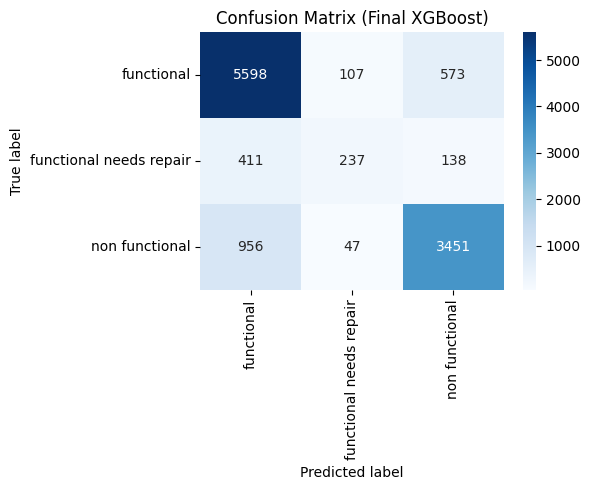

In [17]:
from sklearn.metrics import confusion_matrix
labels = ['functional', 'functional needs repair', 'non functional']

# confusion matrix (rows=true, cols=predicted)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=labels,
    yticklabels=labels
)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix (Final XGBoost)")
plt.tight_layout()
plt.show()

#### Retrain on Full Dataset

In [19]:
# retrain on the *whole* dataset
y_full = pd.concat([
    pd.Series(y_train, index=X_train.index),
    pd.Series(y_test,  index=X_test.index)
], axis=0)

X_full = pd.concat([X_train, X_test], axis=0)

final_model = XGBClassifier(
    **grid_search.best_params_,
    objective='multi:softprob',
    eval_metric='mlogloss',
    num_class=3,
    random_state=42
)
final_model.fit(X_full, y_full)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None, num_class=3, ...)

In [18]:
X_full.shape

(57588, 67)

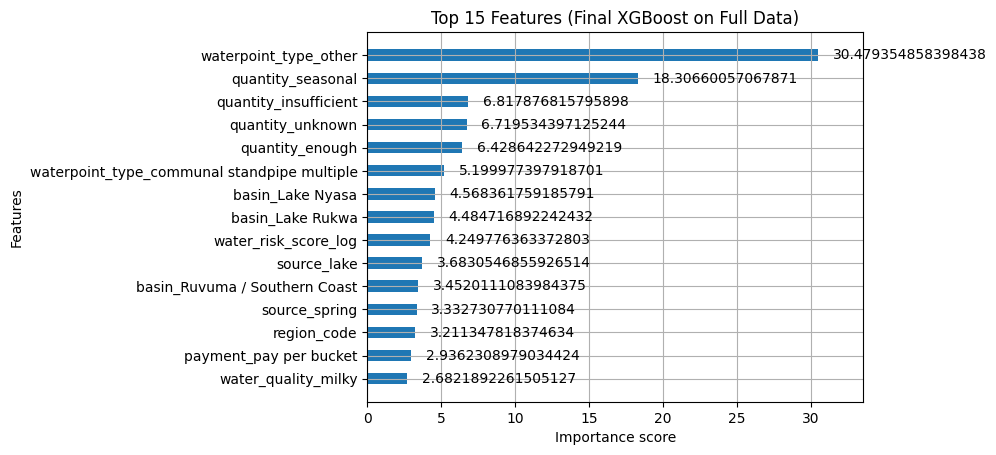

In [20]:
#Plot feature importance
import xgboost as xgb
xgb.plot_importance(final_model, max_num_features=15, importance_type='gain', height=0.5)
plt.title("Top 15 Features (Final XGBoost on Full Data)")
plt.show()